In [1]:
import numpy as np
from gpflowopt.domain import ContinuousParameter
import matplotlib.pyplot as plt
import gpflow
from gpflowopt.bo import BayesianOptimizer
from gpflowopt.design import LatinHyperCube,FactorialDesign,RandomDesign
from gpflowopt.acquisition import ExpectedImprovement
from gpflowopt.optim import SciPyOptimizer, StagedOptimizer, MCOptimizer
import torch
import time 

In [2]:
domain = ContinuousParameter('x1', -1, 1)

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array- value)).argmin()
    return idx

In [4]:
xs = np.arange(-1.0, 1.0, 0.01)
lhd = RandomDesign(2, domain)

In [5]:
func = torch.load('testdata_7000.pt')
func=np.array(func)
num=2
func_test = torch.from_numpy(func[0:num,:])

step=18

In [6]:
min_all=[]
t0 = time.time()
for n in range(num):
    print('Iteration:',n)
    
    def func_1d(x):
        y_out=[]
        for i in range(len(x)):
            idx=find_nearest(xs,x[i])
            y_out.extend([[func_test[n][idx]]])
        y_out=np.array(y_out)
        return y_out

    X = lhd.generate()
    Y = func_1d(X)
    model = gpflow.gpr.GPR(X, Y, gpflow.kernels.RBF(1, ARD=True,variance=0.1))
    model.kern.lengthscales.transform = gpflow.transforms.Log1pe(1e-3)

    # Now create the Bayesian Optimizer
    alpha = ExpectedImprovement(model)
    acquisition_opt = StagedOptimizer([MCOptimizer(domain, 20),SciPyOptimizer(domain)])
    optimizer = BayesianOptimizer(domain, alpha, optimizer=acquisition_opt, verbose=True)
    
    
    # Run the Bayesian optimization
    r = optimizer.optimize(func_1d, n_iter=step)
    print(r)
    min_all.append(np.minimum.accumulate(alpha.data[1][:,0]))

    
    print('time : {:.02e} seconds'.format(time.time() - t0))
t1=time.time() - t0
print('time : {:.02e} seconds'.format(time.time() - t0))

Iteration: 0
iter #  0 - MLL [-4.26] - fmin [0.327]
iter #  1 - MLL [-5.68] - fmin [0.25]
iter #  2 - MLL [-4.48] - fmin [-0.00919]
iter #  3 - MLL [-0.0329] - fmin [-0.551]
iter #  4 - MLL [0.372] - fmin [-0.677]
iter #  5 - MLL [1.45] - fmin [-1.0]
iter #  6 - MLL [-0.0823] - fmin [-1.0]
iter #  7 - MLL [-1.44] - fmin [-1.0]
iter #  8 - MLL [-1.61] - fmin [-1.0]
iter #  9 - MLL [-2.76] - fmin [-1.0]
iter # 10 - MLL [0.3] - fmin [-1.0]
iter # 11 - MLL [-53.3] - fmin [-1.0]
iter # 12 - MLL [-11.2] - fmin [-1.0]
iter # 13 - MLL [3.64] - fmin [-1.0]
iter # 14 - MLL [4.81] - fmin [-1.0]
iter # 15 - MLL [7.53] - fmin [-1.0]
iter # 16 - MLL [10.1] - fmin [-1.0]
iter # 17 - MLL [11.9] - fmin [-1.0]
 constraints: array([], dtype=float64)
         fun: array([-1.])
     message: 'OK'
        nfev: 18
     success: True
           x: array([[1.]])
time : 1.61e+01 seconds
Iteration: 1
iter #  0 - MLL [-4.18] - fmin [0.549]
iter #  1 - MLL [-0.102] - fmin [-1.0]
iter #  2 - MLL [0.845] - fmin [-1

In [7]:
sum_step=0
for i in range(len(min_all)):
    sum_step=sum_step+ np.minimum.accumulate(min_all[i])

In [8]:
min_step =sum_step/len(min_all)
sum2=0
for i in range(len(min_all)):
    sum2=sum2+np.minimum.accumulate(min_all[i])**2

var=sum2/len(min_all)-min_step**2

std=(var/len(min_all))**0.5

/home/weixiang/DML_MF_BO/env3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


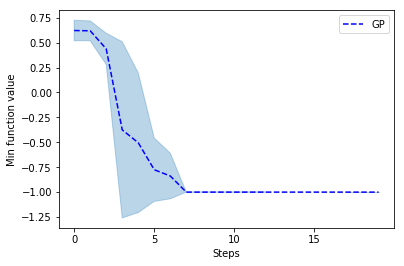

In [10]:
steps=step+2
plt.plot(min_step,'b--',label='GP')
plt.xticks(np.arange(0, steps, 5))
plt.fill_between(np.arange(0, steps, 1), min_step - 2*std, min_step +2*std,color="C0", alpha=0.3) 

plt.legend(loc='upper right')
plt.ylabel('Min function value') 
plt.xlabel('Steps') 
#plt.ylim(-1.5,1)
plt.show()

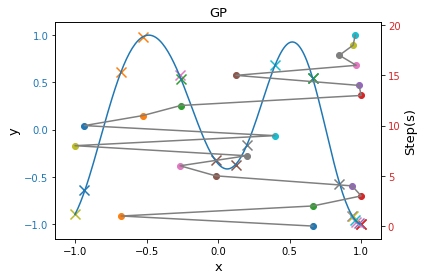

In [13]:
#plot specific function

steps=step+2
color = 'tab:blue'
fig,ax1= plt.subplots()
ax1.set_xlabel('x',size=13)
ax1.set_ylabel('y',size=13)

#GP
ax1.plot(xs,func[1])

ax1.tick_params(axis='y', labelcolor=color)
for i in range(steps):
    ax1.scatter(alpha.data[0][i,0],alpha.data[1][i,0],marker='x',s=100)

ax2 = ax1.twinx()

stepss = np.arange(0, steps, 1)
color = 'tab:red'
ax2.set_ylabel('Step(s)',size=13)  

ax2.plot(alpha.data[0][:,0],stepss, color='tab:grey')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(np.arange(0, steps+1, 5))
for i in range(steps):
    ax2.scatter(alpha.data[0][i,0],i)

plt.title('GP',size=13)
#plt.savefig("query_1.pdf",bbox_inches="tight")
fig.tight_layout() 

In [14]:
#torch.save(min_step, open('min_step_gp', 'wb'))
#torch.save(std, open('std_gp', 'wb'))